# The reproduction of literarure:Computational Rationalization: The Inverse Equilibrium Problem

## Abstract:

Modeling the purposeful behavior of imperfect agents from a small number of observations is a challenging task. When restricted to the single-agent decision-theoretic setting, inverse optimal control techniques assume that observed behavior is an approximately optimal solution to an unknown decision problem. These techniques learn a utility function that explains the example behavior and can then be used to accurately predictor imitate future behavior in similar observedor unobserved situations.In this work, we consider similar tasks in competitive and cooperative multi-agent domains. Here, unlike single-agent settings, a player cannot myopically maximize its reward — it must speculate on how the other agents may act to influence the game’s outcome. Employing the game-theoretic notion of regret and the principle of maximum entropy, we introduce a technique for predicting and generalizing behavior, as well as recovering a reward function in these domains.

## Experiment description:

A simple routing game shown in Figure 1. Seven drivers in this game choose how to travel home during rush hour after a long day at the office. The different road segments have varying capacities, visualized by the line thickness in the figure, that make some of them more or less susceptible to congestion or to traffic accidents. Upon arrival home, each driver records the total time and distance they traveled, the gas that they used, and the amount of time they spent stopped at intersections or in traffic jams – their utility features. 

## Parameter setting:

In figure 1, Black lines represent roads, and each road contains several road segments. The index of each road segment is shown in the figure below. The capacities of road segments are:[1,1,2,3,2,5,2,3,2,2]. A road can be expressed by the sequence of segments it contains. For instance, road1 = [1,3,4,5,7,9],denoting that road1 contains road segments 1,3,4,5,7 and 9. Similiarly, road2 = [1,3,4,6,8,10], road3 = [2,4,5,7,9], road4 = [2,4,6,8,10]. We set the length of each road segment to be 20KM.

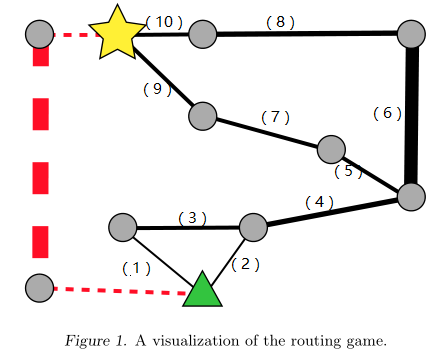

## Code: Part I Generating True Behavior Distribution

1. Import necessary pockages and modules

In [1]:
import numpy as np
from sklearn import linear_model       
import matplotlib.pyplot as plt
import scipy.stats as stats
import operator
import random
import math

2. Define the parameters. Note that, since the variable indexs count from 0, the index of both roads and road segments discussed above should minus 1. Parameter yibusilo is parameter ε of ε-correlated equilibrium: $R^{\Phi ^{swap}}(\sigma ,\omega ^{*})\leq \varepsilon $, where R represents the expected regret with respect to Φ and outcome distribution σ. Parameter omega represent the preference of drivers corresponding to the utility features [the total travle time , the total travel distance, the gas, and the amount of jam time] : they all prefer mainly to minimize their travel time, but were also slightly concerned with gas usage.

In [2]:
route_num = 4 #路径数
driver_num = 7 #司机数
global route_seg_length #每段公路长20公里
route_seg_length= 20 #每段公路长20公里

yibusilo = 0.5

route =np.array([[0,2,3,4,6,8],[0,2,3,5,7,9],[1,3,4,6,8],[1,3,5,7,9]])
#每个路径对应的路段

route_seg_wid=np.array([1,1,2,3,2,5,2,3,2,2])
#每个路段的路宽

omega = [10,0,2,0]#偏好设置

3. Based on the speed limitaion policy in China, we define a function to calculate the car's speed on different road segments. If the number of lanes of a road segment(the capacity) is 1, cars travel in a speed of 50km/h. If the number of lanes is 2, cars can travel at 70km/h. If the road segment contains more than 3 lanes, then this segment can be called as a highway, where cars can travel at 120km/h.

In [5]:
def route_speed_limit(route_wid):
    #输入道路宽度，输出限速：单车道限速50，双车道70，三车道及以上限速120
    speed_limit = 50
    if route_wid == 2:
        speed_limit = 70
    elif route_wid  >= 3:
        speed_limit = 120
    return speed_limit

4. We use the linear model to estimate the the relationship between the oil consumption and the velacity of the car.

In [4]:
X=[[120],[90],[60],[30]] #利用线性回归训练油耗模型
y=[[7.81],[5.86],[4.12],[4.10]]
model = linear_model.LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

5. Define the swap function f.

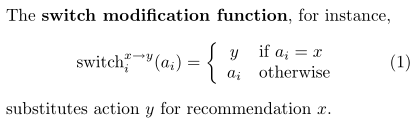

In [6]:
func_f = np.zeros((route_num,route_num-1),dtype = int)
for i in range(route_num):
    k = 0
    for j in range(route_num):     
        if j != i :
            func_f[i][k] = j
            k += 1

func_f_val = np.zeros((len(func_f)*len(func_f[0]),1,2),dtype=int) #把func 变为 12* 1*2 的数组整理起来
i = 0
for j in range(len(func_f)):
    for k in range(len(func_f[j])):
        route_bef = j
        route_aft = func_f[j][k]
        func_f_val[i] = [route_bef,route_aft]
        i += 1

6. For convenience's sake, we use an int to represent the outcome or the joint-actions of all the drivers. For example, we use 123 to represent the outcome [1,3,2,3] which means that driver0 chooses road1, driver1 chooses road3... Apparently, it is an conversion between decimal number and quaternary number in this work. So we define two functions:decode and encode to represent the convertion from decimal number to quaternary number and the convertion from quaternary number to decimal number,respectively.

In [8]:
def ten_four(n,result=[]):
    #将十进制数据变为一组四进制数组，如123->[1,3,2,3],意味着123的四进制表示为1323
    multiple = n//route_num
    reminder = n%route_num
    result.insert(0,reminder)
    if (multiple!=0):
        ten_four(multiple,result)
    return result

def decode(n):
    #状态空间解码函数，将一个整数映射为对应的路径例如：123-> [0,0,0,1,3,2,3]，分别对应7个司机对于四种路径的选择
    action=ten_four(n,[])
    while(len(action) < driver_num):
        action.insert(0,0)
    return np.array(action) 

def encode(list):
    #状态空间解码函数，将对应的路径映射为一个整数例如： [0,0,0,1,3,2,3]->123
    n=0
    for i in range(len(list)):
        n += list[i]*(route_num**(len(list)-i-1))
    return n

7. Define a function to express the represent the relation the joint-actions and the number of cars in each road segment. For example action_route_seg([0,0,0,0,0,0,0]) = [7,0,7,7,7,0,7,0,7,0]

In [9]:
def action_route_seg(act):
    #定义由行为到每个路段中车流量的映射，例如[0,0,0,0,0,0,0]->[7,0,7,7,7,0,7,0,7,0]
    cars_in_seg = np.zeros(10,dtype=int)
    for i in range(len(act)):
        for j in range(len(route[act[i]])) :
            cars_in_seg[route[act[i]][j]] += 1
    return cars_in_seg

8. Define functions to calculate the utility features. The total travel distance equals to the sum of the length of road segments contained by the road. The totla time equals to the sum of the travel time and the jam time. The travel time can be calculated by the total distance divided by speed. Whenever cars in the certain road segment are more than the capacity of this segment, jam occurs. For every extra car, the jam time adds 3min. When the cars are in traffic jam, they consume oil as well. For every 5min waiting in a traffic jam, a car consumes 0.15 litre oil. 

In [10]:
def oil_calculate(v,b_time):
    #根据车速以及等待时间计算油耗
    oil_run = model.predict([[v]])[0][0]*route_seg_length/100
    oil_block = 12*0.15*b_time #等待5分钟等于行驶1公里，按每百公里15公升由计算
    return oil_block+oil_run
     
def route_seg_theta(cars_num,route_wid):
    #根据路段宽度以及车流量，计算每辆车的通过时间，通过路程，消耗燃油量，堵塞时间
    velocity = route_speed_limit(route_wid)
    block_time = 0
    if cars_num > route_wid:
        velocity = route_speed_limit(route_wid)*route_wid/cars_num
        block_time = (cars_num-route_wid)/20 #等待时间为3分钟的倍数
    run_time = route_seg_length/velocity + block_time
    oil_consumption = oil_calculate(velocity,block_time)
    return np.array([run_time,route_seg_length,oil_consumption,block_time])

def theta(act,i):
    #定义theta(a,i)对于行为a，中的第i个决策者的outcome feature
    cars_num = action_route_seg(act)
    action_i = act[i]#第i个决策者的决策
    route_seg_i = route[action_i]#该决策路径对应的路段
    outcome_feature = np.zeros(4,dtype=float)
    for j in range(len(route_seg_i)):#遍历该决策中所有路段
        name_route_seg_i_j = route_seg_i[j] 
        cars_seg = cars_num[name_route_seg_i_j]
        outcome_feature += route_seg_theta(cars_seg,route_seg_wid[name_route_seg_i_j])
    return outcome_feature

9. Define the function of expected regret. 

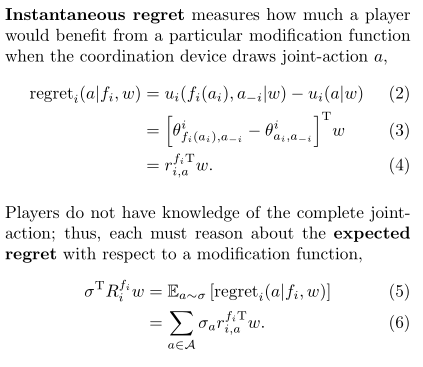

In [11]:
def except_regret(distribution,f,i):
    #regret对于分布的期望，distribution定义为分布[0.1,....,0.005]->1*4^7维向量,f：[原来的路径，现在的路径],输出变换的路径，以及期望regret
    except_reg = 0.0
    code_after = np.zeros(len(distribution),dtype=int)
    for j in range(len(distribution)):       
        action_before = decode(j)       
        action_after = action_before.copy()     
        if action_before[i] == f[0]:
            action_after[i] = f[1]
            code_after[j] = encode(action_after)
            reg = np.array(theta(action_after,i) - theta(action_before,i)).T.dot(np.array(omega))
            except_reg += reg*distribution[j]
        else: 
            code_after[j] = j          
    return code_after,except_reg

10. Define a function to judge if a distribution of outcomes satisfied the ε-correlated equilibrium. If not, update the distribution: for the swap functions resulting high regret, add the probability of the changed outcomes while reduce the probability of the original outcomes.

In [12]:
def equilibrium_det(distribution):
    #判断一个分布是否符合相关均衡，不符合则更新分布
    for i in range(driver_num):
        for j in range(len(func_f)):
            for k in range(len(func_f[j])):
                route_bef = j
                route_aft = func_f[j][k]
                f = [route_bef,route_aft]
                code_after,except_reg = except_regret(distribution,f,i)   
                #print('fail to be equilibrium',i,j,k,except_reg)              
                if except_reg > yibusilo:
                    print('fail to be equilibrium',i,j,k,except_reg)
                    for m in range(len(distribution)):
                        if code_after[m] != m :
                            decline = distribution[m]/2
                            distribution[code_after[m]] += decline
                            distribution[m] -= decline
                    return  False,distribution
    print('equilibrium')
    return True,distribution

11. Calculate the ε-correlated equilibrium distribution to be the true behaviour distribution.

In [ ]:
code = np.arange(0,4**7,1)
distribution_0 = stats.norm.pdf(code,4**7//2,4**7//6)
minus = 1-sum(distribution_0)
distribution_0 += minus/len(distribution_0)             

print(func_f)

while(1):
   TF,distribution_0 = equilibrium_det(distribution_0)
   if TF == True :
       break



aa = np.array(distribution_0)
np.save('distribution_'+str(yibusilo)+'.npy',aa)
print(sum(aa))

## Part II Predicting Behavior Distribution

1. The predicted behavior distribution should satisfy the constrints of rationality assumptions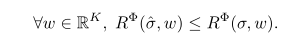  

Note that, the contraint above can be tranformed to 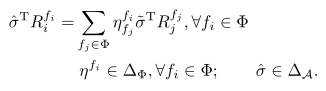 

Then, choose the distribution with the max entropy. So, the mathematical program can be expressed as 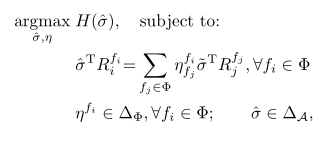

Take the slack penalty parameters into consideration, then the corresponding mathematical program is 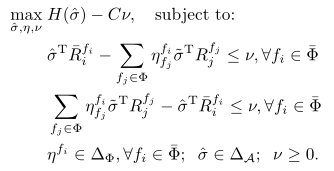 Unfortunately, this mathematical program cannot be solved easily, so the author employs exponentiated gradient descent (Kivinen & Warmuth, 1995) to find an optimal dual solution, which is shown below.

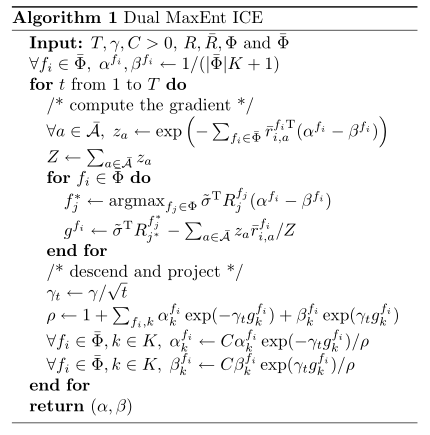

where $\gamma = \sqrt{2log\left |  \bar{\Phi} \right | K}/ \Delta$ Note that, in this numerical experiment, the unobserved game $ \bar{\Gamma}$ is the same as the observed game $ \Gamma$.

## 2. Code of Part II

1. Using roulette sampling to generate demonstrated distribution.

In [ ]:
def RWS(distribution):
    #轮盘赌采样
    rand = random.random()
    pos = 0
    for i in range(len(distribution)):
        pos += distribution[i]
        if (rand <= pos):
            return i
        
distribution_true = np.load('distribution_1.npy') #真实分布
sample_num = 7 #采样数

sample = np.zeros((sample_num,driver_num),dtype=int)

distribution_obt = np.zeros(len(distribution_true),dtype=float) 
for i in range(sample_num):#采样，并记录分布
    rand_code = RWS(distribution_true)
    distribution_obt[rand_code] += 1.0 
    sample[i] = decode(rand_code)
distribution_obt /= sample_num

print(distribution_obt[distribution_obt!=0])

2. Use the algorithm1 showm above to generate the predicted distribution and evaluate the distribution using log-loss method:$-\sum _{a \in A}\sigma _{a}log \hat{\sigma}_{a}$. To prevent the number in log() from being 0, we add the probability of each outcome to 1e-15. 

In [ ]:
def argmax_cal(distribution,f,i,mi):
    #算法中间过程中一步,计算对应于观测分布，观测决策以及alpha，beta的值
    except_reg = 0.0
    for j in range(len(distribution)):       
        action_before = decode(j)       
        action_after = action_before.copy()     
        if action_before[i] == f[0]:
            action_after[i] = f[1]
            reg = np.array(theta(action_after,i) - theta(action_before,i)).dot(np.array(mi))
            except_reg += reg*distribution[j]        
    return except_reg

def cal_r(action_before,f,i):
    #计算r(ia,fi)
    action_after = action_before.copy()
    if action_before[i] == f[0]:
         action_after[i] = f[1]
    
    reg = np.array(theta(action_after,i) - theta(action_before,i))
    return reg

def cal_derta(sample_in):
    #计算derta=largest value in an R i fi
    max_r = 0
    for a in range(len(sample_in)):
        action = sample_in[a]
        for i in range(len(action)):
            for j in range(len(func_f_val)):
                f = func_f_val[j][0]
                r = cal_r(action,f,i).max()
                if r > max_r:
                    max_r = r
    return max_r

def matrix_R(distribution,f,i):
    #计算矩阵R
    R_val = np.zeros((len(distribution),4),dtype=float)
    for j in range(len(distribution)):
        R_val[j] = cal_r(decode(j),f,i)
        return R_val

    R = np.zeros((sample_num,driver_num),dtype=int)
K_val = 4
e_val = 0.5 #对偶问题最优性的松弛
deta = cal_derta(sample) #计算deta用于后续计算

fai_cap = len(func_f_val) *driver_num
fai_ba = np.zeros(fai_cap,dtype=int)
for i in range(sample_num):
    for j in range(len(sample[i])):
        fai_ba[j*len(func_f_val)+sample[i][j]*3] +=1 
        fai_ba[j*len(func_f_val)+sample[i][j]*3+1] +=1
        fai_ba[j*len(func_f_val)+sample[i][j]*3+2] +=1  
fai_ba_cap = sum(fai_ba>0)

gamma_val = math.sqrt(2*math.log(fai_ba_cap*K_val)) / deta #计算梯度下降步长gamma

T_val = math.ceil(2*deta*deta*math.log(fai_ba_cap*K_val) / (e_val*e_val)) #计算迭代总次数
T_val = 50
C_val = 5 #松弛系数，用于权衡强理性约束以及最大熵约束

alpha_val = np.zeros((fai_cap,K_val),dtype=float)
beta_val = np.zeros((fai_cap,K_val),dtype=float)
for i in range(fai_cap):
    alpha_val[i] = 1/(fai_ba_cap*np.array([1,1,1,1])+1)
    beta_val[i] = 1/(fai_ba_cap*np.array([1,1,1,1])+1)


z = np.zeros(len(distribution_obt),dtype=float)
g = np.zeros((fai_cap,K_val),dtype=float)


for t in range(1,T_val+1):
    z_val = 0
    for a in range(len(distribution_obt)):
        sum_val = 0
        action = decode(a)
        for i in range(fai_cap):
            i_val = i//len(func_f_val)
            f = func_f_val[i%len(func_f_val)][0]
                
            reg_val = cal_r(action,f,i_val)

                
            sum_val += reg_val.dot(alpha_val[i]-beta_val[i]) 
        

        z[a]= math.exp(-1*sum_val)
        z_val += z[a]

    for i in range(fai_cap):
        arg_max_val = -50000000
        
       
        for j in range(fai_cap):
            i_val_j = j//len(func_f_val)
            f_j = func_f_val[j%len(func_f_val)][0]
            R_matrix_val_j = matrix_R(distribution_obt,f_j,i_val_j)
            arg_max_try = distribution_obt.dot(R_matrix_val_j).dot(alpha_val[i]-beta_val[i])
            if arg_max_try > arg_max_val:
                arg_max_val = arg_max_try
                arg_max_j = j

        i_val_max = arg_max_j//len(func_f_val)
        f_max = func_f_val[arg_max_j%len(func_f_val)][0]
        R_matrix_val = matrix_R(distribution_obt,f_max,i_val_max)
        g[i] = distribution_obt.dot(R_matrix_val)

        i_val_i = i//len(func_f_val)
        f_i = func_f_val[i%len(func_f_val)][0]
        for a in range(len(distribution_obt)) :
            g[i] = g[i] - (z[a]*cal_r(decode(a),f_i,i_val_i) / z_val)
                
                
    
    

    gamma_t_val = gamma_val / math.sqrt(t)
    rou = 1 
    for i in range(fai_cap):
        for k in range(K_val):
            rou += alpha_val[i][k]*math.exp(-1*gamma_t_val*g[i][k])+beta_val[i][k]*math.exp(gamma_t_val*g[i][k])

    for i in range(fai_cap):
        for k in range(K_val):

            alpha_val[i][k] = C_val*alpha_val[i][k]*math.exp(-1*gamma_t_val*g[i][k])/rou
            beta_val[i][k] = C_val*beta_val[i][k]*math.exp(gamma_t_val*g[i][k])/rou

    
    print(t)
z_alpha_beta = 0.0

z_val = 0.0

for a in range(len(distribution_obt)):
    sum_val = 0
    action = decode(a)
    for i in range(fai_cap):
        i_val = i//len(func_f_val)
        f = func_f_val[i%len(func_f_val)][0]
        reg_val = cal_r(action,f,i_val)
        sum_val += reg_val.dot(alpha_val[i]-beta_val[i])  
                   
    z[a]= math.exp(-1*sum_val)
    z_val += z[a]
    

print(z_val)

distribution_imi = np.zeros(len(distribution_obt),dtype=float)
for a in range(len(distribution_obt)):
    
    sum_val = 0
    action = decode(a)
    
    for i in range(fai_cap):
        i_val = i//len(func_f_val)
        f = func_f_val[i%len(func_f_val)][0]
        reg_val = cal_r(action,f,i_val)
        sum_val += reg_val.dot(alpha_val[i]-beta_val[i])
 
    distribution_imi[a] += math.exp(-1*sum_val)/z_val
    


print(distribution_imi[distribution_imi!=0]) 

log_obt = 0
log_imi = 0
for act in range(len(distribution_obt)):
    
    log_obt += -1*distribution_true[act]*math.log(distribution_obt[act]+1e-15)
    log_imi += -1*distribution_true[act]*math.log(distribution_imi[act]+1e-15)
    
print(log_obt)
print(log_imi)